<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpaca_trade_api

Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [2]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
random_seed = 101
torch.manual_seed(random_seed)

In [4]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [5]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [6]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day


In [7]:
from datetime import date

train_start = date(2017, 1, 1)
train_end = date(2019, 10, 31)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 400
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "USO" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 0 # Number of days to off set the training data
train, val, test, full, offset, complete, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

Number of days of Training Data 1033
Number of days of Validation Data 400
Number of days of Holdout Test Data 421


In [169]:
def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
  Time Frame: 0730-1730
  Backfilling NaNs
  Adjusting Volume to Zero if no Trading data is present
     - Assumption is that there were no trades duing that time  
  """
  
  df = df.between_time('07:29','17:26')

  TZ = 'US/Eastern'

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time', 
                              direction='backward').set_index("Time").between_time('08:29','16:26')

  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v


  filtered_df["Volume"] = volumeset_list
  adjvolumeset_list = []

  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return np.flip(np.rot90((arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)
  

def buildOutData_TorchPrep(train_df = train, val_df = val, test_df = test):
  pass

In [170]:
train = timeFilterAndBackfill(train)
val = timeFilterAndBackfill(val)
test = timeFilterAndBackfill(test)

In [173]:
train.head()

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2017-01-03 08:30:00-05:00,11.97,11.97,11.97,11.97,11300.0,11.970000
2017-01-03 08:35:00-05:00,11.97,11.97,11.96,11.96,2000.0,11.962500
2017-01-03 08:40:00-05:00,11.72,11.97,11.72,11.97,12356.0,11.722023
2017-01-03 08:45:00-05:00,11.96,11.96,11.95,11.96,3231.0,11.958739
2017-01-03 08:50:00-05:00,11.96,11.96,11.92,11.92,66180.0,11.933590


In [174]:
train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()
X_train = blockshaped(train_array, 24, 5)
X_val = blockshaped(val_array, 24, 5)
X_test = blockshaped(test_array, 24, 5)

In [175]:
np.set_printoptions(linewidth=1000)
X_train[0]

array([[1.197000e+01, 1.197000e+01, 1.172000e+01, 1.196000e+01, 1.196000e+01, 1.194000e+01, 1.195000e+01, 1.200000e+01, 1.201000e+01, 1.200000e+01, 1.199000e+01, 1.200000e+01, 1.198000e+01, 1.200000e+01, 1.195000e+01, 1.196000e+01, 1.198900e+01, 1.197010e+01, 1.197000e+01, 1.199000e+01, 1.198680e+01, 1.199000e+01, 1.198000e+01, 1.195000e+01],
       [1.197000e+01, 1.197000e+01, 1.197000e+01, 1.196000e+01, 1.196000e+01, 1.194000e+01, 1.200000e+01, 1.201000e+01, 1.201000e+01, 1.200000e+01, 1.200000e+01, 1.200000e+01, 1.200000e+01, 1.200000e+01, 1.197000e+01, 1.199000e+01, 1.200000e+01, 1.198000e+01, 1.199000e+01, 1.200000e+01, 1.199450e+01, 1.199000e+01, 1.198000e+01, 1.196960e+01],
       [1.197000e+01, 1.196000e+01, 1.172000e+01, 1.195000e+01, 1.192000e+01, 1.194000e+01, 1.195000e+01, 1.200000e+01, 1.200000e+01, 1.199000e+01, 1.199000e+01, 1.198000e+01, 1.198000e+01, 1.195000e+01, 1.194500e+01, 1.196000e+01, 1.197000e+01, 1.196000e+01, 1.197000e+01, 1.198000e+01, 1.198000e+01, 1.196000

In [137]:
# create target from OHLC and Volume Data
def buildTargets(obs_array,  
                 alph = .55, 
                 volity_int = 8):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  returns = np.log(target_close_df['Close']/(target_close_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)
  
  targets = [2] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph * volatility)), 
           1, targets)
  
  targets = np.where(target_close_df.Close.shift(-1) <= (target_close_df.Close * (1 - alph * volatility)), 
           0, targets)

  return targets

In [138]:
volity_val = 2
y_train = buildTargets(X_train, volity_int = volity_val)
y_val = buildTargets(X_val, volity_int = volity_val)
y_test = buildTargets(X_test, volity_int = volity_val)

In [140]:
######
# Code fro scaling at a later date
######

from sklearn.preprocessing import MinMaxScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_val.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

In [141]:
X_train = X_train.reshape(X_train.shape[0], 1,
                          X_train.shape[1], 
                          X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], 1,
                          X_val.shape[1], 
                          X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1,
                          X_test.shape[1], 
                          X_test.shape[2])

In [142]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (5155, 1, 5, 24), y Train Label Length (5155,)
X Val Length (2000, 1, 5, 24), y Val Label Length (2000,)
X Test Length (2105, 1, 5, 24), y Test Label Length (2105,)


In [153]:
X_train[0]

array([[[4.39157724e-01, 4.38413081e-01, 4.34262948e-01, 4.38029972e-01, 4.37708195e-01, 4.38835623e-01, 4.37574791e-01, 4.41176471e-01, 4.41610738e-01, 4.41453567e-01, 4.38926174e-01, 4.36069987e-01, 4.36781609e-01, 4.36314363e-01, 4.03794038e-01, 4.36314363e-01, 4.36866982e-01, 4.35135135e-01, 4.37331536e-01, 4.44069626e-01, 4.46536651e-01, 4.45040214e-01, 4.42958966e-01, 4.44220159e-01],
        [4.37583893e-01, 4.35013263e-01, 4.35590969e-01, 4.37500000e-01, 4.38170074e-01, 4.38829787e-01, 4.38619774e-01, 4.41518825e-01, 4.39523662e-01, 4.38172043e-01, 4.36069987e-01, 4.35016835e-01, 4.35723951e-01, 4.36314363e-01, 4.37077131e-01, 4.35135135e-01, 4.35723951e-01, 4.34547908e-01, 4.42048518e-01, 4.44743935e-01, 4.44295302e-01, 4.42953020e-01, 4.43548387e-01, 4.42054475e-01],
        [4.41227952e-01, 4.39839572e-01, 4.38726536e-01, 4.38666667e-01, 4.41196013e-01, 4.40745672e-01, 4.39252336e-01, 4.44295302e-01, 4.41907320e-01, 4.43097643e-01, 4.40559441e-01, 4.37837838e-01, 4.38810336e

In [154]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

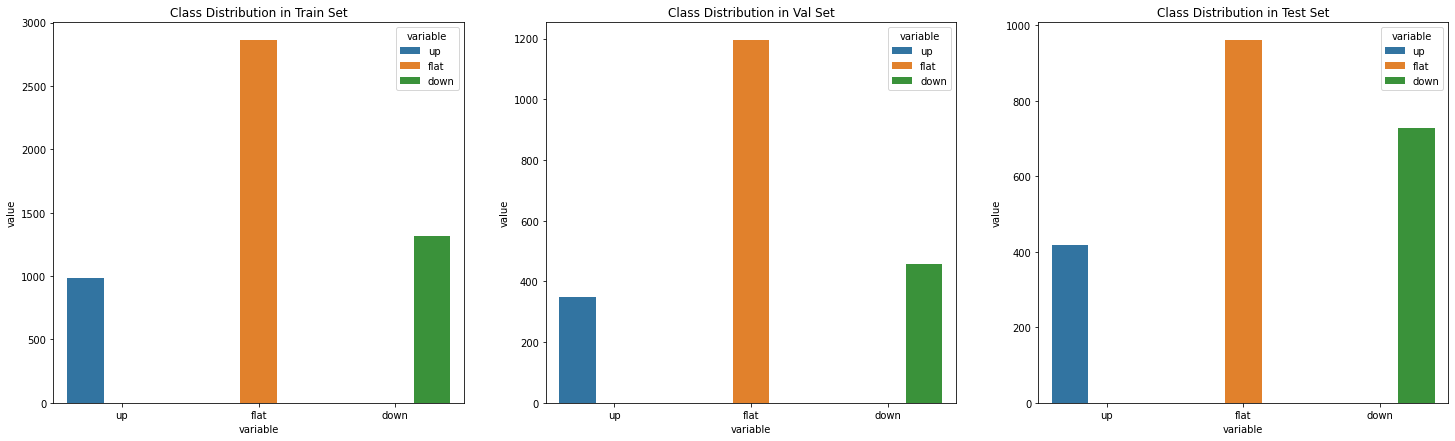

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [156]:
X_train.shape

(5155, 1, 5, 24)

In [157]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')
print("")
print('Training data window: ', len(X_train))
print('Val data windows: ', len(X_val))

X Train Length (5155, 1, 5, 24), y Train Label Length (5155,)
X Val Length (2000, 1, 5, 24), y Val Label Length (2000,)
X Test Length (2105, 1, 5, 24), y Test Label Length (2105,)

Training data window:  5155
Val data windows:  2000


In [158]:
y_train[0].dtype

dtype('int64')

In [159]:
batch_size = 5

train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i].astype('float'), y_train[i]])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batch_size)
i1, l1 = next(iter(train_loader))
print(i1.shape)

val_data = []
for i in range(len(X_val)):
   val_data.append([X_val[i].astype('float'), y_val[i]])

val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)
i1, l1 = next(iter(val_loader))
print(i1.shape)

torch.Size([5, 1, 5, 24])
torch.Size([5, 1, 5, 24])


In [160]:
# Get next batch of training images
windows, labels = iter(train_loader).next()
print(windows.shape)
windows = windows.numpy()

# plot the windows in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    print(labels[idx])

torch.Size([5, 1, 5, 24])
tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(2)


<Figure size 1080x360 with 0 Axes>

In [161]:
class StockShiftClassification(nn.Sequential):
  def __init__(self):
    super(StockShiftClassification, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = (1, 3), stride=1, padding = 1)
    self.pool1 = nn.MaxPool2d(4,4)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = (1, 3), stride=1, padding = 1)
    self.pool2 = nn.MaxPool2d(3,3)  

    self.conv3 = nn.Conv2d(64, 128, kernel_size = (1,3), stride=1, padding = 1)
    self.pool3 = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(128,1000)
    self.fc2 = nn.Linear(1000,500)


  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = x.view(x.size(0), -1)

    # Linear layer
    x = self.fc1(x)
    x = self.fc2(x)

    x = F.softmax(x, dim=1)

    return x


In [162]:
# Instantiate the model
net = StockShiftClassification().float()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(windows.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [5, 32, 7, 24]             128
         MaxPool2d-2              [5, 32, 1, 6]               0
            Conv2d-3              [5, 64, 3, 6]           6,208
         MaxPool2d-4              [5, 64, 1, 2]               0
            Conv2d-5             [5, 128, 3, 2]          24,704
         MaxPool2d-6             [5, 128, 1, 1]               0
            Linear-7                  [5, 1000]         129,000
            Linear-8                   [5, 500]         500,500
Total params: 660,540
Trainable params: 660,540
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.52
Estimated Total Size (MB): 2.87
----------------------------------------------------------------


In [163]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [164]:
def train_model(model,criterion,optimizer,train_loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device).double() # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()
            
            if i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
                running_loss = 0.0

    return loss_over_time

Epoch: 1, Batch: 1000, Avg. Loss: 6.2146
Epoch: 2, Batch: 1000, Avg. Loss: 6.2144
Epoch: 3, Batch: 1000, Avg. Loss: 6.2143
Epoch: 4, Batch: 1000, Avg. Loss: 6.2141
Epoch: 5, Batch: 1000, Avg. Loss: 6.2139
Epoch: 6, Batch: 1000, Avg. Loss: 6.2136
Epoch: 7, Batch: 1000, Avg. Loss: 6.2132
Epoch: 8, Batch: 1000, Avg. Loss: 6.2124
Epoch: 9, Batch: 1000, Avg. Loss: 6.2086
Epoch: 10, Batch: 1000, Avg. Loss: 5.7206
Epoch: 11, Batch: 1000, Avg. Loss: 5.6667
Epoch: 12, Batch: 1000, Avg. Loss: 5.6665
Epoch: 13, Batch: 1000, Avg. Loss: 5.6665
Epoch: 14, Batch: 1000, Avg. Loss: 5.6665
Epoch: 15, Batch: 1000, Avg. Loss: 5.6665
Epoch: 16, Batch: 1000, Avg. Loss: 5.6665
Epoch: 17, Batch: 1000, Avg. Loss: 5.6665
Epoch: 18, Batch: 1000, Avg. Loss: 5.6665
Epoch: 19, Batch: 1000, Avg. Loss: 5.6665
Epoch: 20, Batch: 1000, Avg. Loss: 5.6665
Epoch: 21, Batch: 1000, Avg. Loss: 5.6665
Epoch: 22, Batch: 1000, Avg. Loss: 5.6665
Epoch: 23, Batch: 1000, Avg. Loss: 5.6665
Epoch: 24, Batch: 1000, Avg. Loss: 5.6665
E

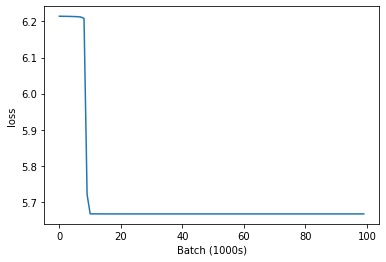

In [165]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 100
cost_path = train_model(net.float(),criterion,optimizer,train_loader,n_epochs,device)

# visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

In [166]:
def test_model(model,test_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(3):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

In [167]:
classes = [0,1,2]

In [168]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(net,val_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(3):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.597
For class 0, recall is 0.0
For class 1, recall is 0.0
For class 2, recall is 1.0


# Working Code

# Loading and Preparing The Data

# Mulitclass Classification (None CDT 1D CNN)

In [ ]:
full.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'VolumeWeightedAvgPrice'],
      dtype='object')

In [ ]:
full["Open"]

timestamp
2016-04-25 10:30:00-04:00     68.81
2016-04-25 10:35:00-04:00     68.88
2016-04-25 10:40:00-04:00     68.91
2016-04-25 10:45:00-04:00     68.90
2016-04-25 10:50:00-04:00     68.94
                              ...  
2021-01-19 08:50:00-05:00    145.00
2021-01-19 09:00:00-05:00    144.98
2021-01-19 09:10:00-05:00    144.98
2021-01-19 09:15:00-05:00    144.93
2021-01-19 09:20:00-05:00    144.81
Name: Open, Length: 124174, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pd.DataFrame()

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_val = scaler.fit_transform(val[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test = scaler.fit_transform(test[['Open', 'High', 'Low', 'Close', 'Volume']])

In [ ]:
train_targets_df = pd.DataFrame(train_targets)
val_targets_df = pd.DataFrame(val_targets)
test_targets_df = pd.DataFrame(test_targets)

class2idx = {
    "up":0,
    "flat":1,
    "down":2,
}

idx2class = {v: k for k, v in class2idx.items()}

train_targets_df.replace(class2idx, inplace=True)
val_targets_df.replace(class2idx, inplace=True)
test_targets_df.replace(class2idx, inplace=True)

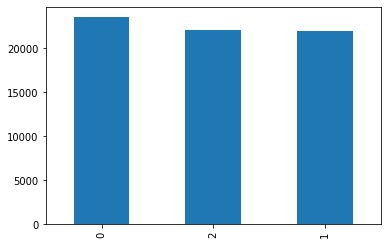

In [ ]:
train_targets_df[0].value_counts().plot(kind = 'bar')

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
  
  # TRAINING
  train_epoch_loss = 0
  train_epoch_acc = 0


  model.train()
  for X_train_batch, y_train_batch in train_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      optimizer.zero_grad()
      
      y_train_pred = model(X_train_batch)
      
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = multi_acc(y_train_pred, y_train_batch)
      
      train_loss.backward()
      optimizer.step()
      
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()
      
      
  # VALIDATION    
  with torch.no_grad():
      
      val_epoch_loss = 0
      val_epoch_acc = 0
      
      model.eval()
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = model(X_val_batch)
                      
          val_loss = criterion(y_val_pred, y_val_batch)
          val_acc = multi_acc(y_val_pred, y_val_batch)
          
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                            

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.03773 | Val Loss: 18.28548 | Train Acc: 46.339| Val Acc: 35.978
Epoch 002: | Train Loss: 1.03568 | Val Loss: 14.71919 | Train Acc: 46.572| Val Acc: 35.846
Epoch 003: | Train Loss: 1.03342 | Val Loss: 16.51808 | Train Acc: 46.793| Val Acc: 36.061
Epoch 004: | Train Loss: 1.03213 | Val Loss: 21.83980 | Train Acc: 46.823| Val Acc: 36.041
Epoch 005: | Train Loss: 1.03002 | Val Loss: 22.58325 | Train Acc: 47.167| Val Acc: 35.862
Epoch 006: | Train Loss: 1.02964 | Val Loss: 22.80922 | Train Acc: 47.228| Val Acc: 35.958
Epoch 007: | Train Loss: 1.02630 | Val Loss: 22.72420 | Train Acc: 47.528| Val Acc: 35.934
Epoch 008: | Train Loss: 1.02479 | Val Loss: 22.38807 | Train Acc: 47.576| Val Acc: 35.902
Epoch 009: | Train Loss: 1.02515 | Val Loss: 22.53223 | Train Acc: 47.479| Val Acc: 36.077
Epoch 010: | Train Loss: 1.02227 | Val Loss: 23.79687 | Train Acc: 47.802| Val Acc: 35.974
Epoch 011: | Train Loss: 1.02061 | Val Loss: 24.85404 | Train Acc: 47.934| Val Acc: 35.866

KeyboardInterrupt: ignored

# APPENDIX

In [ ]:
plot_df = pd.DataFrame(full_targets, columns=["FuturePrice"])

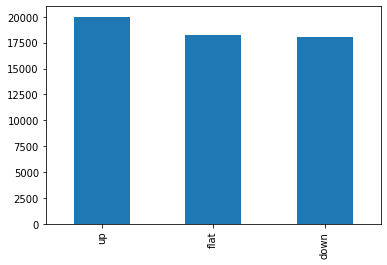

In [ ]:
plot_df["FuturePrice"].value_counts().plot(kind = 'bar')

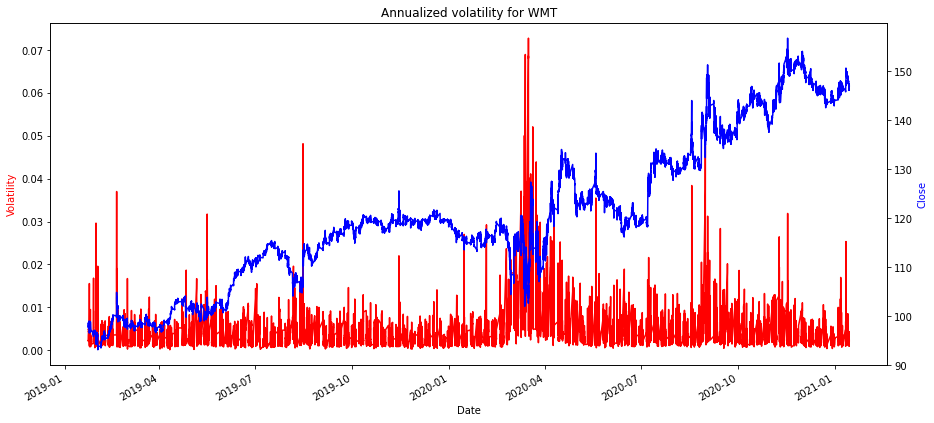

In [ ]:
def buildTargets_VolOnly(full_df = full, train_observations = train.shape[0], 
                         val_observations = val.shape[0], 
                         test_observations = test.shape[0], 
                         alph = 0.55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
plt.show()

In [ ]:
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
full.drop(columns=['Time', ])

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
data=load_breast_cancer(as_frame=True)

In [ ]:
data.target

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64